In [1]:
# imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Marvin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Marvin\anaconda3\lib\site-packages\pypsa\networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



# Import der Basisdaten

### HIER MÜSSEN WIR NOCH EINMAL FESTHALTEN WOHER UNSERE DATEN KOMMEN UND DAS SAUBER AUFLISTEN

### PV-Daten: Renewables.Ninja
Basierend auf Europäischem Datenset:CM-SAF SARAH (Europe) hohe Genauigkeit, da Angabe aus (lon/lat) -> VLH = 1072

### Temperaturdaten: DWD open database
Basierend auf historischen Daten für das Jahr 2022 der Wetterstation am Flughafen Köln/Bonn (ca. 12km Luftlinie)
-> Kälteanomalie im Dezember: kurzzeitig Temperaturen bis -10-Grad

In [2]:
# data imports
df_data = pd.read_csv("data/Modellierung_SoSe23.csv", sep=";", decimal=",", usecols=[0,1,4])

# load pv_data
pv_data = pd.read_csv("data/ninja_pv_50.8263_6.9721.csv", decimal=".", header=3)

# load and prepare temp data
temp_data = pd.read_csv("data/DWD_wetterdaten_KoelnBonn_Flughafen.txt", sep=";", decimal=".", usecols=[1,3])
temp_data = temp_data[(temp_data['MESS_DATUM'] >= 2022010100) & (temp_data['MESS_DATUM'] < 2023010101)]

# fill dataframe
df_data['pv'] = pv_data['electricity'].to_numpy()
df_data['temp'] = temp_data['TT_TU'].to_numpy()

df_data

,Zeit,electric_load,heat_load,pv,temp
0,01.01. 00:00,0.016247,0.22,0.0,12.6
1,01.01. 01:00,0.016162,0.13,0.0,13.0
2,01.01. 02:00,0.016005,0.07,0.0,12.6
3,01.01. 03:00,0.166450,0.03,0.0,12.2
4,01.01. 04:00,0.016200,0.07,0.0,12.8
...,...,...,...,...,...
8755,31.12. 19:00,1.107500,1.69,0.0,15.1
8756,31.12. 20:00,0.261240,1.73,0.0,15.9
8757,31.12. 21:00,0.289830,1.33,0.0,15.9
8758,31.12. 22:00,0.340810,0.81,0.0,15.6


In [3]:
# calculation and data preparation for heat_pump(wp)

# scraped data
wp_data = {
    "temp" : [-22, -15, -7, 2, 7, 10, 12, 20, 25, 30, 35],
    "heating_power" : [0, 25.50, 35.20, 43.00, 56.40, 60.30, 62.90, 67.30, 70.40, 73.60, 76.70],
    "el_power" : [0, 14.58, 15.54, 16.70, 18.54, 18.87, 18.87, 19.05, 19.13, 19.36, 19.46],
    "cop" : [0, 1.7, 2.3, 2.6, 3.0, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]
}

# assumptions
wp_el_p_nom = 12.5  # kW

# calculate COP
df_data["wp_COP_interp"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["cop"]),3)
df_data["wp_power_consumption"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["el_power"]),2)
df_data['wp_power_cons_norm'] = df_data["wp_power_consumption"] / wp_el_p_nom

df_data

,Zeit,electric_load,heat_load,pv,temp,wp_COP_interp,wp_power_consumption,wp_power_cons_norm
0,01.01. 00:00,0.016247,0.22,0.0,12.6,3.315,18.88,1.5104
1,01.01. 01:00,0.016162,0.13,0.0,13.0,3.325,18.89,1.5112
2,01.01. 02:00,0.016005,0.07,0.0,12.6,3.315,18.88,1.5104
3,01.01. 03:00,0.166450,0.03,0.0,12.2,3.305,18.87,1.5096
4,01.01. 04:00,0.016200,0.07,0.0,12.8,3.320,18.89,1.5112
...,...,...,...,...,...,...,...,...
8755,31.12. 19:00,1.107500,1.69,0.0,15.1,3.378,18.94,1.5152
8756,31.12. 20:00,0.261240,1.73,0.0,15.9,3.398,18.96,1.5168
8757,31.12. 21:00,0.289830,1.33,0.0,15.9,3.398,18.96,1.5168
8758,31.12. 22:00,0.340810,0.81,0.0,15.6,3.390,18.95,1.5160


# Parameter- und Variablendefinition

### Komponentenparameter
Für eine leichtere Lesbarkeit und einfachere Zuordnung aller festgelegten Basisparameter, werden Basisdaten in Dictionarys mit eindeutigen Keys definiert

### Basisvariablen 
Generelle Basisvariablen wie z.B. der Strompreis oder die Gebäudedefinition werden in einfachen globalen Variablen gespeichert

In [4]:
# basicvariables
# cost related variables
electricity_rate = 0.4 # €/kWh
infeed_rate = -0.08    # €/kWh
gas_price = 0.158

# building related variables
living_space = 157 #m²

# grid parameters


# data calculations 
# -> here <-------------------!


# component parameters
# PV-plant
pv_params = {
    'p_nom': 10,    # kWp
    'p_max_pu': df_data['pv'],
    'capital_cost': (1300*10)/20,
    'marginal_cost': 0,
    'lifespan' : 20,
    'pv_co2': 0   #kg/kWh
}

# FuelCell -> fc
fc_params = {
    'p_nom': 1.5, #kW_el Brennstoffzellenleistung picea
    'el_efficiency': 0.8,
    'th_efficiency': 0.2,
    'capital_cost': 800,
    'marginal_cost': 0
}

# Electrolyser -> ely
ely_params = {
    'p_nom': 2.3, #kW_el Wasserstofferzeugungsleistung picea
    'el_efficiency': 0.625,
    'th_efficiency': 0.2,
    'capital_cost': 900,
    'marginal_cost': 0
}

# heatpump -> wp
wp_params = {
    'p_nom': 2.5,
    'efficiency': df_data['wp_COP_interp'],
    'capital_cost': (25000 / 7.5) / 25,
    'marginal_cost': 0
}

# battery storage
battery_params = { # battery integrated in picea system
    'e_nom': 20, #kWh picea system
    'e_nom_min': 1,
    #'e_max_pu': 1.0,
    'capital_cost': 892/12.5,
    'marginal_cost': 0,
    'standing_loss': 0.02,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
}

# heat storage
heat_storage_params = {
    'e_nom': 300, #kWh
    'e_min_pu': 0.6,
    'e_max_pu': 1.0,
    'volume': 300, #Litre
    'capital_cost': 53.32/20,
    'marginal_cost': 0,
    'standing_loss': 0.08,
    'charge_efficiency': 0.95,
    'discharge_efficiency': 0.95,
}

# H2 gas storage
h2_storage_params = {
    'e_nom': 300, #kWh_el - picea, auf 1500 kWh_el erweiterbar
    #'e_min_pu_hydrogen': 0.6,
    #'e_max_pu_hydrogen': 1.0,
    'capital_cost': 1000, #€ picea system
    'marginal_cost': 0,
    'standing_loss': 0.001,
    'h2_co2': 0   #kg/kWh
}

#CO2 emissions

co2_params = {
    'co2_emissions_germany_electricity': 0.375 #kg/kWh
}

# Funktionsdefinitionen

## Aufbau des Referenznetzwerks



In [5]:
def build_ref_network():

    # initialyze network
    n_ref = pypsa.Network()
    n_ref.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_ref.add('Carrier', name = 'grid_electricity', 
                co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_ref.add('Carrier', name = 'pv_electricity', 
                co2_emissions = pv_params['pv_co2'])

    
    # Buses 
    # electrical buses
    n_ref.add('Bus', name='electricity')
    n_ref.add('Bus', name='bat_bus')    
    #n_ref.add('Bus', name='house_IO')   # Überschussknoten -> Haus In- und Output
    # heat buses
    n_ref.add('Bus', name='heat')
    n_ref.add('Bus', name='heat_storage_bus')


    # Loads
    # electrical
    n_ref.add('Load', name='electric_load', bus='electricity',
              p_set = df_data['electric_load'])
    # heat
    n_ref.add('Load', name='heat_load', bus='heat', 
              p_set = df_data['heat_load'])

    # Generators
    # PV
    n_ref.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'],
             carrier = 'pv_electricity')
    # grid  
    n_ref.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_ref.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, carrier = 'grid_electricity',
              p_nom_extendable = True)


    # Storages
    n_ref.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              standing_loss = battery_params['standing_loss'], 
              e_nom_min = battery_params['e_nom_min'],
              e_nom_extendable = True)
    n_ref.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom_extendable = True)


    # Links
    n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              efficiency = battery_params['charge_efficiency'],
              p_nom_extendable = True)
    n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              efficiency = battery_params['discharge_efficiency'],
              p_nom_extendable = True)
  #  n_ref.add('Link', name='housegrid_in', bus0='houde_IO', bus1='electricity', 
  #            p_nom_extendable = True)
  #  n_ref.add('Link', name='housegrid_out', bus0='electricity', bus1='house_IO', 
  #            p_nom_extendable = True)
    n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom = wp_params['p_nom'])
    n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable = True)
    n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable = True)
    
    # Global Constraints
    n_ref.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
            carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_ref

In [6]:
n_ref = build_ref_network()
n_ref.optimize(solver_name='gurobi')

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.88it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-18


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-fcw9rxw2.lp
Reading time = 0.34 seconds
obj: 227769 rows, 105128 columns, 438006 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227769 rows, 105128 columns and 438006 nonzeros
Model fingerprint: 0xdd3a54f6
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 175241 rows and 26335 columns
Presolve time: 0.25s
Presolved: 52528 rows, 78793 columns, 175131 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227769 duals
Objective: 9.08e+02
Solver model: available
Solver message: 2



('ok', 'optimal')

## Aufbau des Wasserstoff Netzwerkes

In [6]:
def build_h2_network():
    
    # setup Multilinks
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
    n_h2.set_snapshots(range(8760))

    # add components
    
    # Carrier
    
    n_h2.add('Carrier', name = 'grid_electricity', 
                co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_h2.add('Carrier', name = 'pv_electricity', 
                co2_emissions = pv_params['pv_co2'])
    n_h2.add('Carrier', name = 'h2_electricity', 
                co2_emissions = h2_storage_params['h2_co2'])
    # Buses 
    # electrical buses
    n_h2.add('Bus', name='electricity')
    n_h2.add('Bus', name='bat_bus')    
    #n_h2.add('Bus', name='house_IO')   # Überschussknoten -> Haus In- und Output
    # heat buses
    n_h2.add('Bus', name='heat')
    n_h2.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2.add('Bus', name='h2_bus')

    # Loads
    # electrical
    n_h2.add('Load', name='electric_load', bus='electricity',
              p_set = df_data['electric_load'])
    # heat
    n_h2.add('Load', name='heat_load', bus='heat', 
              p_set = df_data['heat_load'])

    # Generators
    # PV
    n_h2.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'],
            carrier = 'pv_electricity')
    # grid  
    n_h2.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate,
              p_nom_extendable = True, carrier = 'grid_electricity')


    # Storages
    n_h2.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              standing_loss = battery_params['standing_loss'],
              e_nom = battery_params['e_nom'])
    n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              e_nom = heat_storage_params['e_nom'],
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'])
    n_h2.add('Store', name= 'h2_storage', bus='h2_bus',
              capital_cost = h2_storage_params['capital_cost'],
              standing_loss = h2_storage_params['standing_loss'],
              e_nom_extendable = True)


    # Links
    n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              efficiency = battery_params['charge_efficiency'],
              p_nom_extendable = True)
    n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              efficiency = battery_params['discharge_efficiency'],
              p_nom_extendable = True)
    #n_h2.add('Link', name='housegrid_in', bus0='house_IO', bus1='electricity', 
              #p_nom_extendable = True)

    n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom = wp_params['p_nom'])
    n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable = True)
    n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable = True)
    
    # Multilinks
    # electrolysis
    n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
             efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True,
            carrier = 'h2_electricity')
    # fuellcell
    n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
             efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True,
            carrier = 'h2_electricity')
    
    # Global Constraints
    n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
            carrier_attribute = 'co2_emissions', constant = np.inf)
    return n_h2

## Auswertungsfunktion

### Auswertungsverlauf je nach Netzwerk: Prüfen, welches Netzwerk vorhanden

- wenn Wasserstoffnetzwerk n_h2 vorhanden, dann durchlaufe die erste Auswertungsfunktion
- wenn anderes Netzwerk, dann durchlaufe die andere Auswertungsfunktion

### Auswertung

- CO2-Emissionen der Carrier vom Netzwerk und Generatoren addieren zu Gesamtemission des Netzwerks in "co2"
- Betriebskosten Netzwerk pro Jahr in "laufende_kosten" berechnen (generators, links, stores)
- Kapitalkosten Netzwerk pro Jahr (Annuität)
- Gesamtkosten: Betriebskosten + Annuitäten
- Einspeisevergütung berechnen
    - für H2-Netzwerk Vergütung = 0, wegen Bedingung: gesamte PV-Erzeugung selbst verbrauchen
- jährliche Einsparung der Betriebskosten (marginalen Kosten) berechnen bezogen auf eine __fossile Standardversorgung__
    - Betriebskosten fossile Standardversorgung:
        (Netzbezug x Strompreis Netz) + (thermische Kosten * Gaspreis)
        
        __Hier unbedingt nachprüfen, kann so nicht richtig sein, da wir eine Wärmepumpe haben!__
        
        
    - jährliche Einsparung = Fossile Betriebskosten - (Betriebskosten jetziges Netz)
- Amortisationsberechnung
    - Anschaffungskosten / Einsparung
    - Anschaffungkosten: Investitionskosten der Komponenten über den Betrachtungszeitraum
        - PV-Anlage: 20 Jahre
        - Batteriespeicher: 12,5 Jahre __(hier also mehr berechnen)__
        - Pufferspeicher: 20 Jahre
        - Wärmepumpe: 20 Jahre
            __*- H2-Speicher + Elektrolyseur + Brennstoffzelle: 20 Jahre?*__

### Es sollem folgende Werte ausgegeben werden:

- Strombezug aus dem Netz
- Netzeinspeisung (bei H2-Netzwerk = 0)
- PV-Ertrag
- Batteriekapazität
    - Einspeicherung
    - Ausspeicherung
- Pufferspeicherkapaziät
- Leistung Wärmepumpe
- CO2-Emissionen [kg/a]
- Kosten
    - Investition
    - Betriebskosten
    - Einspeisevergütung
    - ursprüngliche Energiekosten (fossiles Standardmodell)
    - Kapital- & mariginale Kosten
    - Einsparung (ggü. fossilem Modell)

In [30]:
def auswertungsfunktion(network, sensitivity_variable=0, co2_constraint=0):
    #Funktion der laufenden kosten
    if network == n_h2:
        
        #co2 Calculation for whole network
        co2 = (network.generators_t.p.sum() / network.generators.efficiency
               * pd.merge(network.carriers, network.generators.carrier, left_index = True,
                          right_on = 'carrier')['co2_emissions']).sum()
        
        #Funktion der laufende Kosten
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost['grid']).sum()
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt['pv'] * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = 0


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p['grid']).sum()
        netzeinspeisung_summe= 0
        pv_ertrag_summe = (network.generators_t.p['pv']).sum()
        einspeicherung_summe = 0 #(network.links_t.p['charge_bat']).sum()
        ausspeicherung_summe = 0 #(network.links_t.p['discharge_bat']).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt['battery'])
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt['heat_storage'])#*36.85)
        Leistung_wp = (network.links.p_nom_opt['wp'])



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable], columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Einsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)
    else:
       
        #co2 Calculation
        co2 = (network.generators_t.p.sum() / network.generators.efficiency
               * pd.merge(network.carriers, network.generators.carrier, left_index = True,
                          right_on = 'carrier')['co2_emissions']).sum()
       
        #Funktion der laufende Kosten 
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid + 
                                      network.generators_t.p.infeed * network.generators.marginal_cost.infeed).sum()
        
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt['pv'] * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = (network.generators_t.p.infeed).sum()*electricity_rate *-1


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p['grid']).sum()
        netzeinspeisung_summe= (network.generators_t.p['infeed']).sum()
        pv_ertrag_summe = (network.generators_t.p['pv']).sum()
        einspeicherung_summe = 0 #(network.links_t.p['charge_bat']).sum()
        ausspeicherung_summe = 0 #(network.links_t.p['discharge_bat']).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt['battery'])
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt['heat_storage'])#*36.85)
        Leistung_wp = (network.links.p_nom_opt['wp'])



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)

    return df_result

## Berechnung der Ergebnisse

Die Ergebnisse werden in eine Liste eingelesen.

Es wird einmal ein Dataframe für die Busse geschaffen (ts_buses), ein Dataframe für die Generatoren des Netzewerkes (ts_gen).
Diese Dataframes werden in die Liste __ts_results__ eingelesen.

Folgende Ergebnisse werden berechnet:

- Netzbezug [kWh/a] mit "power_supply"
- Netzeinspeisung [kWh/a] mit "netzeinspeisung_summe"
- PV-Ertrag [kWh/a] mit "pv_ertrag_summe"
- Einspeicherung in die Batterie [kWh/a] mit "charge_bat"
- Ausspeicherung aus der Batterie [kWh/a] mit "ausspeicherung_summe"
- Batteriekapazität [kWh] mit "battery_capacity"
- Pufferspeicherkapazität [kWh] mit "Kapazität_Pufferspeicher"
- Wärmepumpenleistung [kW] mit "Leistung_wp"

In [8]:
def calculate_results(network):
    
    # list of all timeseries resulting from optimization
    ts_results = []
    
    ts_buses = pd.DataFrame(network.buses_t)
    ts_gen = pd.DataFrame(network.generators_t)
    
    ts_results.append(ts_buses, ts_gen)
    
    
    power_supply = network.generators_t.p.grid
    netzeinspeisung_summe= network.generators_t.p.infeed
    pv_ertrag_summe = network.generators_t.p.pv
    charge_bat = network.links_t.p0.charge_bat
    ausspeicherung_summe = network.links_t.p0.discharge_bat
    battery_capacity = network.stores.e_nom_opt.battery
    Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
    Leistung_wp = (network.links.p_nom_opt.wp)
    
    return ts_results

# Erste Optimierung des Referenznetzwerks

Optimierung, um Größe der Batterie und des Pufferspeichers zu bestimmen.

In [9]:
n_ref = build_ref_network()
n_ref.optimize(solver_name='gurobi')

battery_params['e_nom'] = n_ref.stores.e_nom_opt.battery
heat_storage_params['e_nom'] = n_ref.stores.e_nom_opt.heat_storage


print("batterie: ", battery_params['e_nom'], "\nheat storage: ", heat_storage_params['e_nom'])
n_h2 = build_h2_network()


n_h2.optimize(solver_name='gurobi')

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.73it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-18


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-rj2vhr02.lp
Reading time = 0.37 seconds
obj: 227769 rows, 105128 columns, 438006 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227769 rows, 105128 columns and 438006 nonzeros
Model fingerprint: 0xdd3a54f6
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 175241 rows and 26335 columns
Presolve time: 0.29s
Presolved: 52528 rows, 78793 columns, 175131 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227769 duals
Objective: 9.08e+02
Solver model: available
Solver message: 2



batterie:  2.8259734996629526 
heat storage:  15.23717478587973


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 25.49it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-iw7ji0t5.lp
Reading time = 0.46 seconds
obj: 280329 rows, 131408 columns, 551885 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 280329 rows, 131408 columns and 551885 nonzeros
Model fingerprint: 0x5b36e270
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [4e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 210253 rows and 30711 columns
Presolve time: 0.25s
Presolved: 70076 rows, 100697 columns, 258362 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131408 primals, 280329 duals
Objective: 1.18e+03
Solver model: available
Solver message: 2



('ok', 'optimal')

ref network grid supply:  2950.0571834880384
h2 network grid supply:  2947.11892452535


<Axes: xlabel='snapshot'>

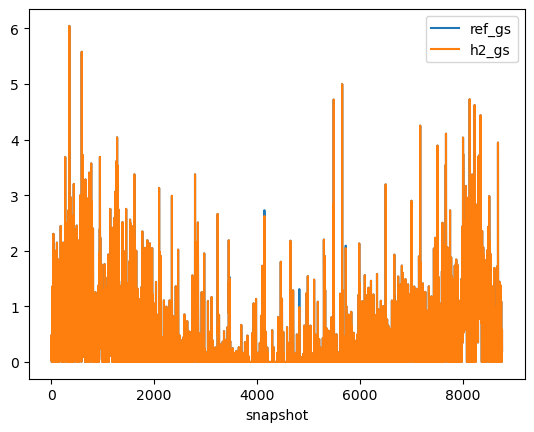

In [10]:
ref_gs = n_ref.generators_t.p.grid.sum()
h2_gs = n_h2.generators_t.p.grid.sum()
el_load = df_data['electric_load'].sum()

print("ref network grid supply: ", ref_gs)
print("h2 network grid supply: ", h2_gs)

res = pd.DataFrame()
res['ref_gs'] = n_ref.generators_t.p.grid
res['h2_gs'] = n_h2.generators_t.p.grid

res.plot()

In [11]:
n_ref.generators_t.p.grid

snapshot
0       0.082612
1       0.055260
2       0.037121
3       0.175527
4       0.037284
          ...   
8755    0.381783
8756    0.261240
8757    0.350859
8758    0.579748
8759    0.196564
Name: grid, Length: 8760, dtype: float64

In [12]:
n_ref.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
charge_bat,electricity,bat_bus,,AC,0.98,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,2.883646
discharge_bat,bat_bus,electricity,,AC,0.98,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,2.769454
wp,electricity,heat,,AC,1.00,0,inf,2.5,False,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,2.500000
charge_heat,heat,heat_storage_bus,,AC,0.95,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,9.305000
discharge_heat,heat_storage_bus,heat,,AC,0.95,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,5.073684


In [13]:
n_h2.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,bus2,efficiency2
Link,,,,,,,,,,,,,,,,,,,,,
charge_bat,electricity,bat_bus,,AC,0.980,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,62.759363,,0.0
discharge_bat,bat_bus,electricity,,AC,0.980,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,61.447657,,0.0
wp,electricity,heat,,AC,1.000,0,inf,2.5,False,0.0,...,0,1,0,NaN,NaN,1.0,1.0,2.500000,,0.0
charge_heat,heat,heat_storage_bus,,AC,0.950,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,67.045895,,0.0
discharge_heat,heat_storage_bus,heat,,AC,0.950,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,62.474626,,0.0
ely,electricity,h2_bus,,h2_electricity,0.625,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.000000,heat,0.2
fc,h2_bus,electricity,,h2_electricity,0.800,0,inf,0.0,True,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.000000,heat,0.2


In [14]:
n_ref.stores

attribute,bus,type,carrier,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,...,p_set,q_set,sign,marginal_cost,marginal_cost_quadratic,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
battery,bat_bus,,AC,0.0,True,1.0,inf,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,71.360,0.02,0,inf,2.825973
heat_storage,heat_storage_bus,,AC,0.0,True,0.0,inf,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.666,0.08,0,inf,15.237175


In [15]:
n_h2.stores

attribute,bus,type,carrier,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,...,p_set,q_set,sign,marginal_cost,marginal_cost_quadratic,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
battery,bat_bus,,AC,2.825973,False,0.0,inf,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,71.360,0.020,0,inf,2.825973
heat_storage,heat_storage_bus,,AC,15.237175,False,0.0,inf,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.666,0.080,0,inf,15.237175
h2_storage,h2_bus,,AC,0.000000,True,0.0,inf,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1000.000,0.001,0,inf,0.000000


In [16]:
n_ref.stores_t.e.sum()

Store
battery          4595.552692
heat_storage    16251.695348
dtype: float64

In [17]:
#co2
n_h2.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen

#Iterationen
#n_ref = build_ref_network()
#n_h2 = build_h2_network()
#n_h2.optimize(solver_name='gurobi')
#results_ref = pd.DataFrame()
#results_h2 = pd.DataFrame()
results_h2 = pd.DataFrame(auswertungsfunktion(n_h2,100,0))
basis_co2_emissions = results_h2['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


for co2_limit in np.flip(np.arange(0.8, 1, 0.05)):
    print(co2_limit* basis_co2_emissions)
    n_h2.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_h2.optimize(solver_name='gurobi', method = 0)
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, co2_limit * 100))
    
'''
for strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.4)): 
    print(strompreis_bezug)
    n_ref.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_h2.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_ref.optimize(solver_name = 'gurobi')
    n_h2.optimize(solver_name='gurobi')
    n_h2.stores.loc['battery', 'e_nom'] = n_ref.stores.e_nom_opt.battery
    n_h2.stores.loc['heat_storage', 'e_nom'] = n_ref.stores.e_nom_opt.heat_storage
    
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, strompreis_bezug))
    results_ref = results_ref.append(auswertungsfunktion(n_ref, strompreis_bezug))

'''

[1049.91111686]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 0
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 25.66it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-7fu_xwb9.lp
Reading time = 0.46 seconds
obj: 280329 rows, 131408 columns, 551885 nonzeros
Set parameter Method to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 280329 rows, 131408 columns and 551885 nonzeros
Model fingerprint: 0xdfef069f
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [4e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+03]
Presolve removed 210252 rows and 30710 columns
Presolve time: 0.23s
Presolved: 70077 rows, 100698 columns, 267126 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1199052e+03   1.241151e+05   5.235111e+11      0s
   10457    1.1199052e+03   1.509144e+03   8.048385e+09      5s
 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131408 primals, 280329 duals
Objective: 2.23e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_15556\764305072.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[994.65263703]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 0
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 25.61it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-rsbwdazh.lp
Reading time = 0.48 seconds
obj: 280329 rows, 131408 columns, 551885 nonzeros
Set parameter Method to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 280329 rows, 131408 columns and 551885 nonzeros
Model fingerprint: 0x59829591
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [4e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+03]
Presolve removed 210252 rows and 30710 columns
Presolve time: 0.24s
Presolved: 70077 rows, 100698 columns, 267126 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0609628e+03   1.241079e+05   5.235111e+11      0s
   10711    1.0609628e+03   1.476639e+03   7.797408e+09      5s
 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131408 primals, 280329 duals
Objective: 3.63e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_15556\764305072.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[939.39415719]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 0
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 26.76it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-_fd9pm1b.lp
Reading time = 0.44 seconds
obj: 280329 rows, 131408 columns, 551885 nonzeros
Set parameter Method to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 280329 rows, 131408 columns and 551885 nonzeros
Model fingerprint: 0xe8e63844
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [4e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 9e+02]
Presolve removed 210252 rows and 30710 columns
Presolve time: 0.23s
Presolved: 70077 rows, 100698 columns, 267126 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0020204e+03   1.241007e+05   5.235111e+11      0s
   10759    1.0020204e+03   1.495624e+03   7.538123e+09      5s
 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131408 primals, 280329 duals
Objective: 5.69e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_15556\764305072.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[884.13567736]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 0
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 25.89it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-yctn6zau.lp
Reading time = 0.44 seconds
obj: 280329 rows, 131408 columns, 551885 nonzeros
Set parameter Method to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 280329 rows, 131408 columns and 551885 nonzeros
Model fingerprint: 0x2e69e915
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [4e-01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 9e+02]
Presolve removed 210252 rows and 30710 columns
Presolve time: 0.21s
Presolved: 70077 rows, 100698 columns, 267126 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.4307806e+02   1.240935e+05   5.235111e+11      0s
   10807    9.4307806e+02   1.529948e+03   7.441938e+09      5s
 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131408 primals, 280329 duals
Objective: 8.80e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_15556\764305072.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



"\nfor strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.4)): \n    print(strompreis_bezug)\n    n_ref.generators.loc['grid', 'marginal_cost'] = strompreis_bezug\n    n_h2.generators.loc['grid', 'marginal_cost'] = strompreis_bezug\n    n_ref.optimize(solver_name = 'gurobi')\n    n_h2.optimize(solver_name='gurobi')\n    n_h2.stores.loc['battery', 'e_nom'] = n_ref.stores.e_nom_opt.battery\n    n_h2.stores.loc['heat_storage', 'e_nom'] = n_ref.stores.e_nom_opt.heat_storage\n    \n    results_h2 = results_h2.append(auswertungsfunktion(n_h2, strompreis_bezug))\n    results_ref = results_ref.append(auswertungsfunktion(n_ref, strompreis_bezug))\n\n"

In [18]:
# Achtung Test

n_h2.generators.p_nom_opt['grid']

6.045828493999226

In [19]:
n_ref.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen

#n_ref = build_ref_network()
#n_h2 = build_h2_network()
#n_ref.optimize(solver_name='gurobi')

results_ref = pd.DataFrame(auswertungsfunktion(n_ref,100,0))
basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


#results_ref = pd.DataFrame(auswertungsfunktion(n_ref,100,0))
#basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen

for co2_limit in np.flip(np.arange(0.8, 1, 0.05)):
    print(co2_limit* basis_co2_emissions)
    n_ref.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_ref.optimize(solver_name='gurobi', method = 0)
    results_ref = results_ref.append(auswertungsfunktion(n_ref, co2_limit * 100))

[1050.95787162]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 0
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 32.75it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-dpythz68.lp
Reading time = 0.35 seconds
obj: 227769 rows, 105128 columns, 438006 nonzeros
Set parameter Method to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227769 rows, 105128 columns and 438006 nonzeros
Model fingerprint: 0x30e1eff5
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+03]
Presolve removed 175239 rows and 26334 columns
Presolve time: 0.25s
Presolved: 52530 rows, 78794 columns, 183895 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1221166e+03   1.201022e+05   3.688418e+11      0s
   15101    1.1200217e+03   2.586358e+02   1.661496e+09      5s
  

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227769 duals
Objective: 9.12e+02
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_15556\3305212731.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[995.64429943]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 0
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.77it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-sc20l8ni.lp
Reading time = 0.35 seconds
obj: 227769 rows, 105128 columns, 438006 nonzeros
Set parameter Method to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227769 rows, 105128 columns and 438006 nonzeros
Model fingerprint: 0x45818618
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+03]
Presolve removed 175239 rows and 26334 columns
Presolve time: 0.25s
Presolved: 52530 rows, 78794 columns, 183895 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0630564e+03   1.200964e+05   3.688418e+11      0s
   24047    1.0619940e+03   2.035158e+02   6.217614e+08      5s
  

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227769 duals
Objective: 9.25e+02
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_15556\3305212731.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[940.33072724]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 0
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 32.61it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-46ix3ajz.lp
Reading time = 0.36 seconds
obj: 227769 rows, 105128 columns, 438006 nonzeros
Set parameter Method to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227769 rows, 105128 columns and 438006 nonzeros
Model fingerprint: 0xbf80d62d
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 9e+02]
Presolve removed 175239 rows and 26334 columns
Presolve time: 0.24s
Presolved: 52530 rows, 78794 columns, 183895 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0039963e+03   1.200906e+05   3.688418e+11      0s
   23357    1.0029740e+03   2.096795e+02   6.042527e+08      5s
  

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227769 duals
Objective: 9.56e+02
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_15556\3305212731.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[885.01715505]


INFO:linopy.model: Solve linear problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 0
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 33.37it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-0p8k8mk5.lp
Reading time = 0.34 seconds
obj: 227769 rows, 105128 columns, 438006 nonzeros
Set parameter Method to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227769 rows, 105128 columns and 438006 nonzeros
Model fingerprint: 0xa43cbdb1
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 9e+02]
Presolve removed 175239 rows and 26334 columns
Presolve time: 0.24s
Presolved: 52530 rows, 78794 columns, 183895 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.4493614e+02   1.200848e+05   3.688418e+11      0s
   24916    9.4399175e+02   1.800468e+02   3.673015e+08      5s
  

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227769 duals
Objective: 1.02e+03
Solver model: available
Solver message: 2

C:\Users\Marvin\AppData\Local\Temp\ipykernel_15556\3305212731.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [20]:
n_ref.generators.p_nom_opt

Generator
pv        10.000000
infeed     8.042504
grid       6.045828
Name: p_nom_opt, dtype: float64

In [21]:
results_ref

,CO2_emissions in kg/a,Kapital- und marginale kosten €/a,Verbrauchseinsparung €/a,Marginale Kosten €/a,Ursprüngliche Energiekosten €/a,Investitionskosten €/a,Einspeiseverguetung €/a,Amortisationsdauer a,Netzbezug kWh/a,Netzeinspeisung kWh/a,PV-Ertragssumme kWh/a,Einspeicherung kWh/a,Auspeicherung kWh/a,Pufferspeicherkapazität kWh,Batteriepeicherkapazität kWh,Leistung Wärmepumpe kW
100.0,1106.271444,7741.336790,2235.948861,665.719680,2901.668541,7075.617110,-2571.515966,63.289615,2950.057183,6428.789915,10724.82,0,0,15.237175,2.825973,2.5
95.0,1050.957872,7744.940620,2279.155496,622.513044,2901.668541,7122.427576,-2492.543426,62.500585,2802.554324,6231.358565,10724.82,0,0,16.773068,3.424569,2.5
90.0,995.644299,7758.030076,2321.329682,580.338859,2901.668541,7177.691217,-2408.408637,61.841205,2655.051465,6021.021592,10724.82,0,0,19.653672,4.091384,2.5
85.0,940.330727,7789.816440,2364.478394,537.190147,2901.668541,7252.626292,-2329.146476,61.346522,2507.548606,5822.866190,10724.82,0,0,23.205404,5.008791,2.5
80.0,885.017155,7855.388325,2406.741117,494.927424,2901.668541,7360.460901,-2245.454374,61.165373,2360.045747,5613.635935,10724.82,0,0,27.432002,6.362021,2.5


In [22]:
results_h2 

,CO2_emissions in kg/a,Kapital- und marginale kosten €/a,Einsparung €/a,Marginale Kosten €/a,Ursprüngliche Energiekosten €/a,Investitionskosten €/a,Einspeiseverguetung €/a,Amortisationsdauer a,Netzbezug kWh/a,Netzeinspeisung kWh/a,PV-Ertragssumme kWh/a,Einspeicherung kWh/a,Auspeicherung kWh/a,Pufferspeicherkapazität kWh,Batteriepeicherkapazität kWh,Leistung Wärmepumpe kW
100.0,1105.169597,8254.464680,1722.820971,1178.847570,2901.668541,7075.617110,0,82.139900,2947.118925,0,5202.554027,0,0,15.237175,2.825973,2.5
95.0,1049.911117,9309.043305,1781.763349,1119.905191,2901.668541,8189.138114,0,91.921726,2799.762978,0,4861.634085,0,0,15.237175,2.825973,2.5
90.0,994.652637,10709.191860,1840.705728,1060.962813,2901.668541,9648.229048,0,104.831847,2652.407032,0,5071.544939,0,0,15.237175,2.825973,2.5
85.0,939.394157,12770.444797,1899.648106,1002.020434,2901.668541,11768.424363,0,123.901099,2505.051086,0,5319.104086,0,0,15.237175,2.825973,2.5
80.0,884.135677,15873.473317,1958.590485,943.078056,2901.668541,14930.395261,0,152.460613,2357.695140,0,5574.371733,0,0,15.237175,2.825973,2.5


<Axes: xlabel='snapshot'>

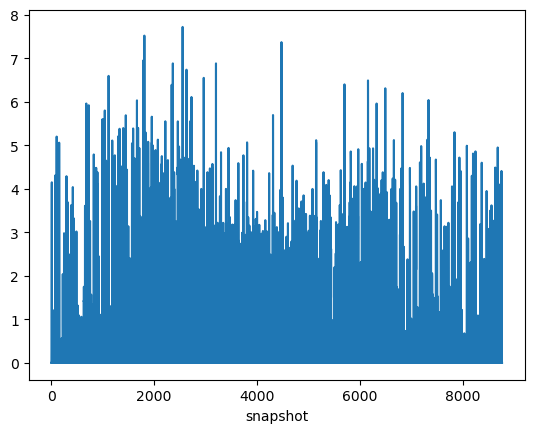

In [23]:
n_h2.generators_t.p.pv.plot()

<Axes: xlabel='snapshot'>

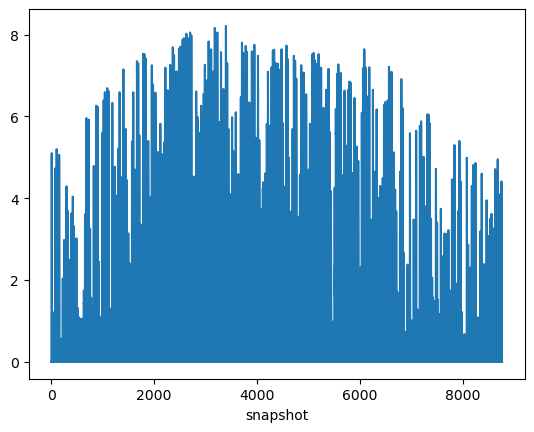

In [24]:
n_ref.generators_t.p.pv.plot()

<Axes: xlabel='snapshot'>

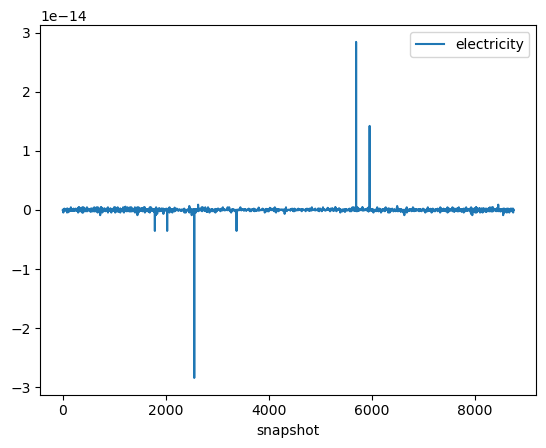

In [25]:
n_h2.buses_t.p.plot(y='electricity')

In [26]:
n_ref.generators.capital_cost.pv

650.0

In [27]:
pv_params['capital_cost']

650.0

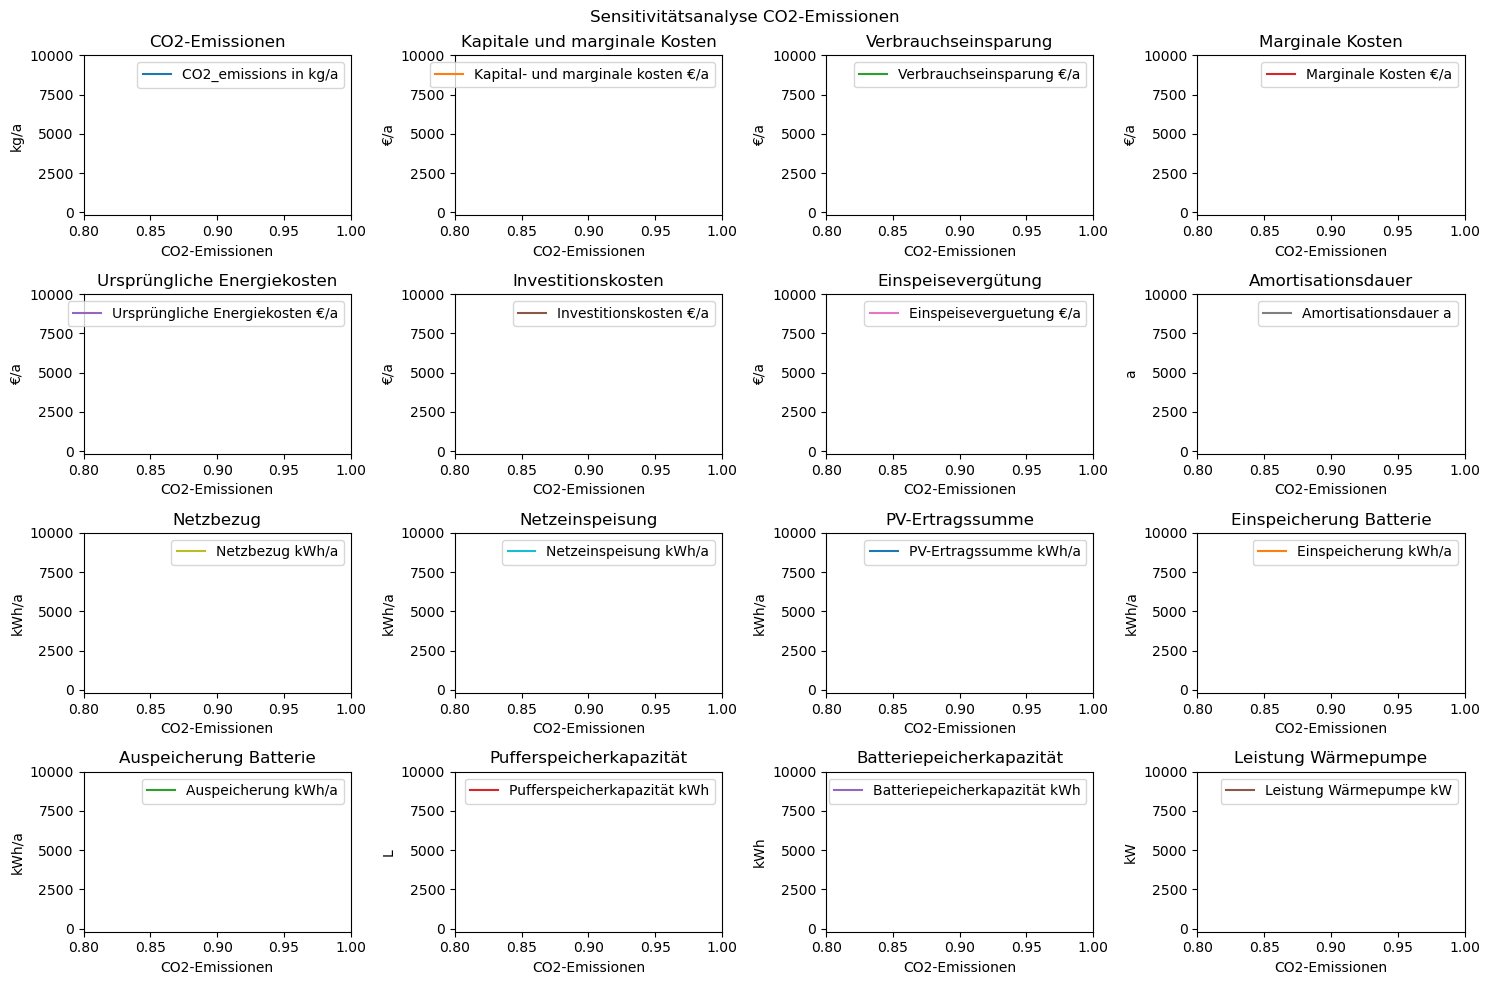

In [28]:
#Anzahl der Diagramme, Achsenbeschriftung und Überschriften festlegen
# Call up of the function results, clearing of the results DF
results_ref.drop(results_ref.index, inplace=True)  
results_ref.index.name = 'CO2-Emissionen'
 

fig, axes = plt.subplots(nrows=4, ncols=4, figsize = (15,10), subplot_kw={'xlim': (0.8, 1.0), 'ylim': (-200, 10000)})
results_ref.plot(subplots=True, ax=axes)

 

axes[0,0].set_ylabel('kg/a') 
axes[0,1].set_ylabel('€/a')
axes[0,2].set_ylabel('€/a')
axes[0,3].set_ylabel('€/a')
axes[1,0].set_ylabel('€/a')
axes[1,1].set_ylabel('€/a') 
axes[1,2].set_ylabel('€/a')
axes[1,3].set_ylabel('a')
axes[2,0].set_ylabel('kWh/a')                  
axes[2,1].set_ylabel('kWh/a')
axes[2,2].set_ylabel('kWh/a')
axes[2,3].set_ylabel('kWh/a')
axes[3,0].set_ylabel('kWh/a')
axes[3,1].set_ylabel('L')            
axes[3,2].set_ylabel('kWh')
axes[3,3].set_ylabel('kW')

 


axes[0,0].set_title('CO2-Emissionen')
axes[0,1].set_title('Kapitale und marginale Kosten')
axes[0,2].set_title('Verbrauchseinsparung')
axes[0,3].set_title('Marginale Kosten')
axes[1,0].set_title('Ursprüngliche Energiekosten')
axes[1,1].set_title('Investitionskosten')
axes[1,2].set_title('Einspeisevergütung')
axes[1,3].set_title('Amortisationsdauer')
axes[2,0].set_title('Netzbezug')
axes[2,1].set_title('Netzeinspeisung')
axes[2,2].set_title('PV-Ertragssumme')
axes[2,3].set_title('Einspeicherung Batterie')
axes[3,0].set_title('Auspeicherung Batterie')
axes[3,1].set_title('Pufferspeicherkapazität')
axes[3,2].set_title('Batteriepeicherkapazität')
axes[3,3].set_title('Leistung Wärmepumpe')

 


fig.suptitle('Sensitivitätsanalyse CO2-Emissionen')
fig.tight_layout()

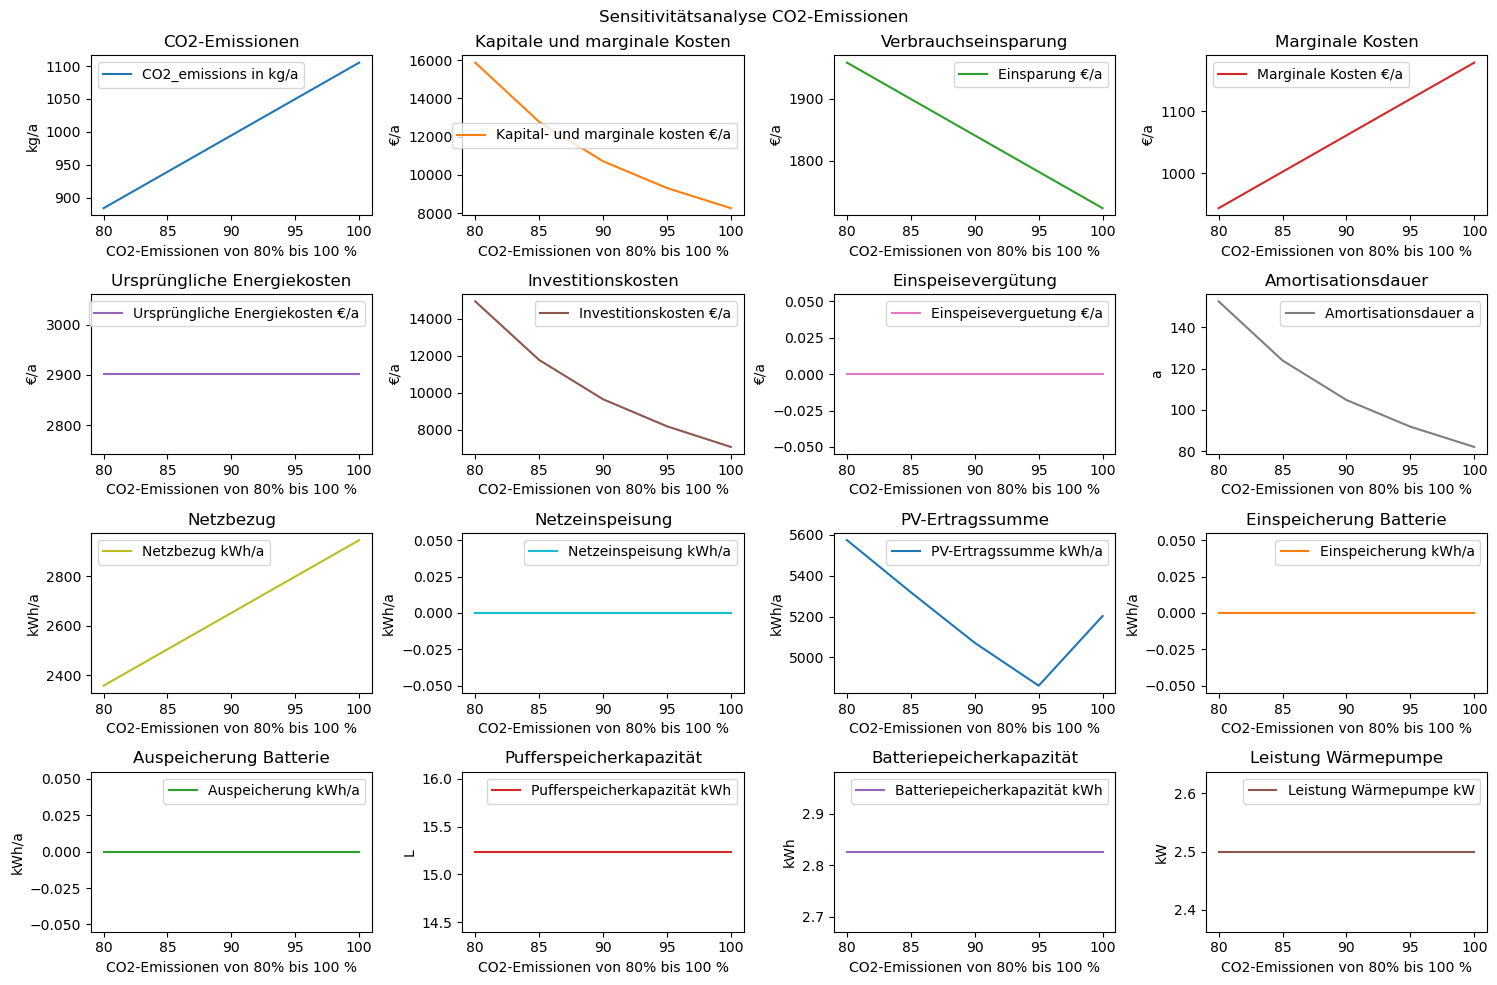

In [29]:
#Anzahl der Diagramme, Achsenbeschriftung und Überschriften festlegen
# Call up of the function results, clearing of the results DF
results_h2.drop(results_ref.index, inplace=True)  
results_h2.index.name = 'CO2-Emissionen von 80% bis 100 %'
 

fig, axes = plt.subplots(nrows=4, ncols=4, figsize = (15,10))
results_h2.plot(subplots=True, ax=axes)

 

axes[0,0].set_ylabel('kg/a') 
axes[0,1].set_ylabel('€/a')
axes[0,2].set_ylabel('€/a')
axes[0,3].set_ylabel('€/a')
axes[1,0].set_ylabel('€/a')
axes[1,1].set_ylabel('€/a') 
axes[1,2].set_ylabel('€/a')
axes[1,3].set_ylabel('a')
axes[2,0].set_ylabel('kWh/a')                  
axes[2,1].set_ylabel('kWh/a')
axes[2,2].set_ylabel('kWh/a')
axes[2,3].set_ylabel('kWh/a')
axes[3,0].set_ylabel('kWh/a')
axes[3,1].set_ylabel('L')            
axes[3,2].set_ylabel('kWh')
axes[3,3].set_ylabel('kW')

 


axes[0,0].set_title('CO2-Emissionen')
axes[0,1].set_title('Kapitale und marginale Kosten')
axes[0,2].set_title('Verbrauchseinsparung')
axes[0,3].set_title('Marginale Kosten')
axes[1,0].set_title('Ursprüngliche Energiekosten')
axes[1,1].set_title('Investitionskosten')
axes[1,2].set_title('Einspeisevergütung')
axes[1,3].set_title('Amortisationsdauer')
axes[2,0].set_title('Netzbezug')
axes[2,1].set_title('Netzeinspeisung')
axes[2,2].set_title('PV-Ertragssumme')
axes[2,3].set_title('Einspeicherung Batterie')
axes[3,0].set_title('Auspeicherung Batterie')
axes[3,1].set_title('Pufferspeicherkapazität')
axes[3,2].set_title('Batteriepeicherkapazität')
axes[3,3].set_title('Leistung Wärmepumpe')

 


fig.suptitle('Sensitivitätsanalyse CO2-Emissionen')
fig.tight_layout()